# Demonstration of `DroneWQ` functions and processing code

## Summary 

This notebook provides an example workflow of DroneWQ using multispectral images collected by the MicaSense RedEdge-MX sensor over western Lake Erie on August 17, 2022. The workflow processes raw imagery to remote sensing reflectance and applies bio-optical algorithms to retrieve chlorophyll a concentrations. It georeferences the images producing a final chlorophyll a mosaic of the full dataset. <br>

The Lake Erie drone dataset can be found in the [Zenodo DOI](https://doi.org/10.5281/zenodo.14018788), please note it is 5.84 GB unzipped. Depending on computer speed, you may need to subset the data before running the code workflow shown here. 

## Contents

1. [Setup](#1.-Setup)
2. [View metadata](#2.-View-metadata)
3. [Process raw to Rrs](#3.-Process-raw-imagery-to-remote-sensing-reflectance-(Rrs)-and-visualize-data)
4. [Convert to point samples](#4.-Convert-to-point-samples)
5. [Apply bio-optical algorithms](#5.-Apply-bio-optical-algorithms)
6. [Georeference and mosaic](#6.-Georeference-and-mosaic-chlorophyll-a-images)

## 1. Setup

Pull in all the libraries needed for this notebook.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy.crs import Mercator
import matplotlib.image as mpimg

plt.rcParams['mathtext.default'] = 'regular'

import dronewq
from dronewq.utils import settings
import glob
import contextily as cx


Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want but keep the rest exactly as named here):
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to your main_dir below. Here, we have the main_dir called 'Lake_Erie'.

In [7]:
dronewq.configure(main_dir='Lake_Erie')
settings = dronewq.settings

raw_water = settings.raw_water_dir
rrs = settings.rrs_dir
project_path = settings.main_dir

project_path = dronewq.settings.main_dir

## 2. View metadata

MicaSense raw images contain metatdata including imager information, GPS coordianates, and more. We can use the `write_metadata_csv()` function to extract image metadata and save it as .csv. 

Let's open the first five lines of the .csv to take a look.

In [8]:
dronewq.write_metadata_csv(settings.raw_water_dir, settings.main_dir)

img_metadata = pd.read_csv(os.path.join(settings.main_dir, 'metadata.csv'))
img_metadata.head()

Loading ImageSet from: Lake_Erie/raw_water_imgs


,filename,dirname,DateStamp,TimeStamp,Latitude,LatitudeRef,Longitude,LongitudeRef,Altitude,SensorX,...,FocalLength,Yaw,Pitch,Roll,SolarElevation,ImageWidth,ImageHeight,XResolution,YResolution,ResolutionUnits
0,capture_1.tif,Lake_Erie/capture_1.tif,2022-08-17,15:37:04,41.828528,N,-83.398762,W,265.061,4.8,...,5.43432,218.376096,25.899967,335.837017,0.895362,1280,960,266.666667,266.666667,mm
1,capture_2.tif,Lake_Erie/capture_2.tif,2022-08-17,15:37:08,41.828670,N,-83.398764,W,265.554,4.8,...,5.43432,221.427592,16.821391,341.184053,0.895530,1280,960,266.666667,266.666667,mm
2,capture_3.tif,Lake_Erie/capture_3.tif,2022-08-17,15:37:10,41.828809,N,-83.398760,W,265.968,4.8,...,5.43432,218.898605,16.695405,343.643092,0.895655,1280,960,266.666667,266.666667,mm
3,capture_4.tif,Lake_Erie/capture_4.tif,2022-08-17,15:37:13,41.828956,N,-83.398761,W,266.420,4.8,...,5.43432,216.716936,18.188710,345.889851,0.895738,1280,960,266.666667,266.666667,mm
4,capture_5.tif,Lake_Erie/capture_5.tif,2022-08-17,15:37:16,41.829081,N,-83.398763,W,267.018,4.8,...,5.43432,214.429136,18.385695,347.772515,0.895863,1280,960,266.666667,266.666667,mm


We can plot the altitude and lat,lon, and yaw angle metadata of the image captures to get a sense of the flight plan.

Text(0, 0.5, 'Yaw')

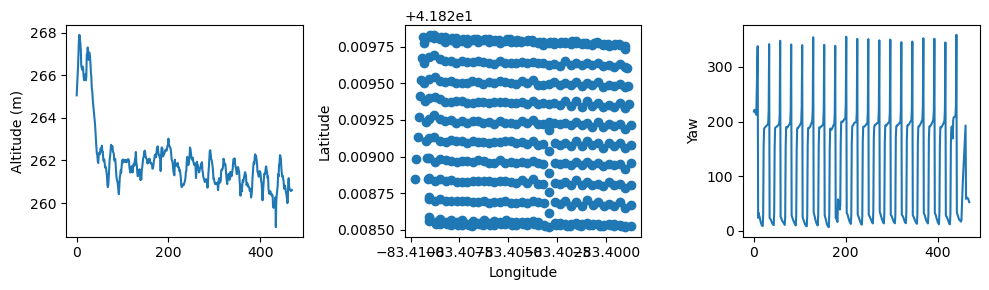

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='tight')

ax[0].plot(list(range(len(img_metadata))),img_metadata['Altitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(img_metadata['Longitude'], img_metadata['Latitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

ax[2].plot(list(range(len(img_metadata))),img_metadata['Yaw'])
ax[2].set_ylabel('Yaw')

## 3. Process raw imagery to remote sensing reflectance (Rrs) and visualize data

Now let's get to processing. 
The `process_raw_to_rrs()` function has a number of options that you can see here:

In [ ]:
?dronewq.process_raw_to_rrs

For this example, we're calculating water leaving radiance (Lw) using the Hedley approach and calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS). We are applying the default masking procedure using a NIR threshold of 0.02. We'll save processed images out to two directories called `rrs_hedley` and `masked_rrs_hedley`. Please see the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html) for more information on the different processing methods used here. 

In summary, this code will process: Raw -> Lt -> Lw (Hedley method) -> Rrs (using Ed from DLS) with pixel masking.

Note that we are changing the default nir_threshold for pixel masking from 0.01 to 0.02 since 0.01 was not high enough to mask glint pixels in this dataset. It is important to consider these values since they may change according to your dataset. 

In [6]:
dronewq.process_raw_to_rrs(output_csv_path=settings.main_dir, lw_method='hedley_method', 
                   random_n=10, mask_pixels=True, pixel_masking_method='value_threshold', nir_threshold=0.02, ed_method='dls_ed', 
                   overwrite_lt_lw=True, clean_intermediates=False, num_workers=4)


Loading ImageSet from: /Users/artemis/Downloads/Lake_Erie/align_img
Processing a total of 2351 images or 470 captures.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: /Users/artemis/Downloads/Lake_Erie/raw_water_imgs
Loading ImageSet from: /Users/artemis/Downloads/Lake_Erie/align_img
used warp dir /Users/artemis/Downloads/Lake_Erie/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished aligning band 1


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Saving time: 0:03:39.263187
Alignment+Saving rate: 2.14 images per second
Finished saving images.
Loading ImageSet from: /Users/artemis/Downloads/Lake_Erie/raw_water_imgs
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = Datase

Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: /Users/artemis/Downloads/Lake_Erie/raw_water_imgs


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib

Processed 470 files successfully
All data has been saved as Rrs using the hedley_method to calculate Lw and normalized by dls_ed irradiance.
Masking pixels using NIR and green Rrs thresholds


/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/opt/anaconda3/envs/dronewq/lib

To grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows you to apply an altitude cutoff and limit the number of files being opened. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

In [ ]:
?retrieve_imgs_and_metadata

Let's retrieve the Rrs data (5 bands) and visualize the first 5 images:

<>:14: DeprecationWarning: invalid escape sequence '\ '


Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


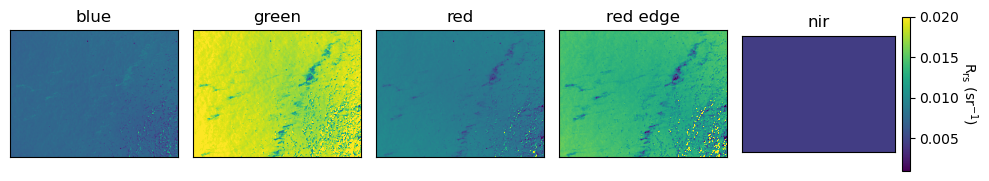

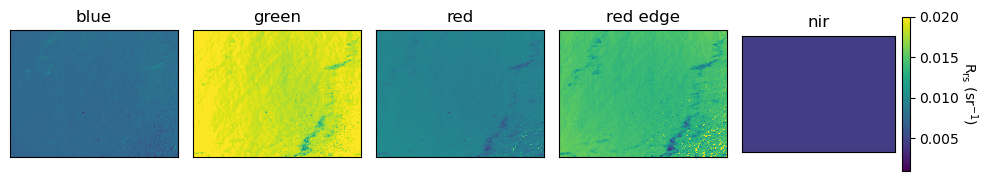

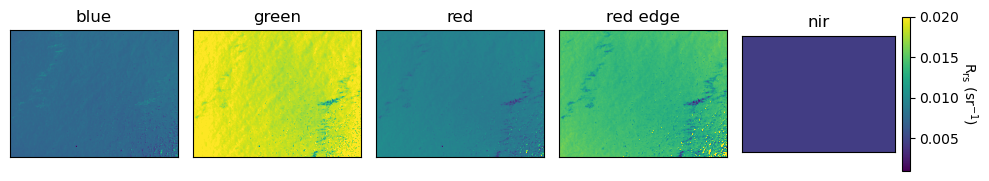

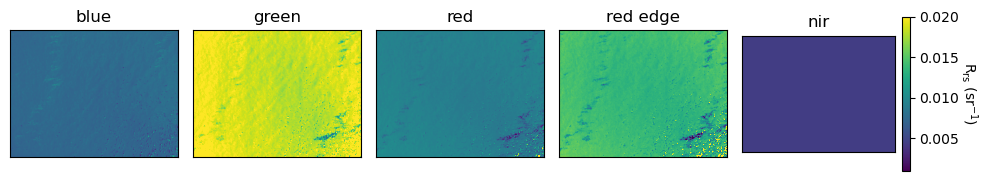

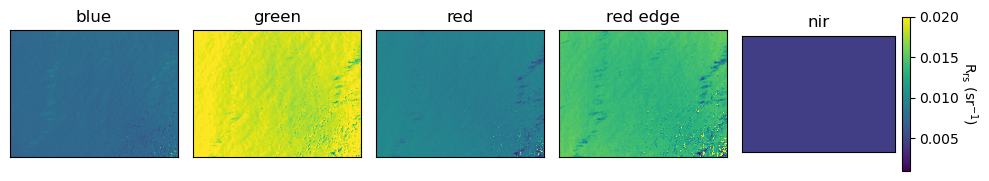

In [ ]:

rrs_imgs_hedley_gen = dronewq.load_imgs(img_dir=settings.rrs_dir, start=0, count=5)

rrs_img_hedley = np.array(list(rrs_imgs_hedley_gen))

print(img_metadata.index)

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i], cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

We can also visualize the masked Rrs:

<>:12: DeprecationWarning: invalid escape sequence '\ '


Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif'],
      dtype='object', name='filename')


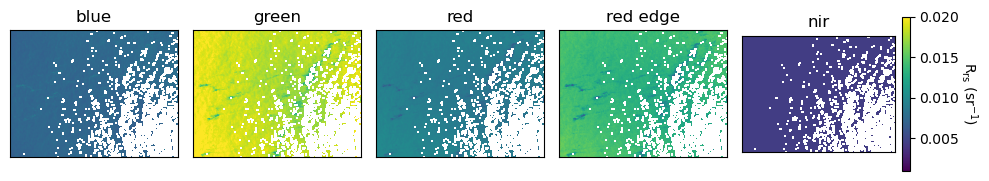

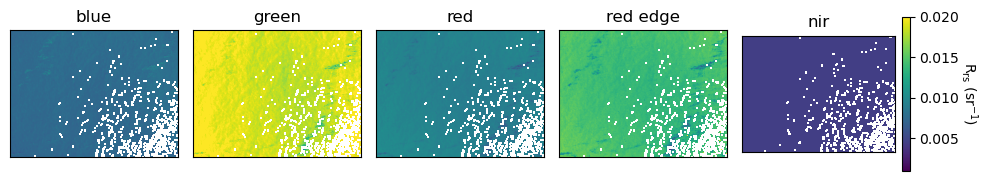

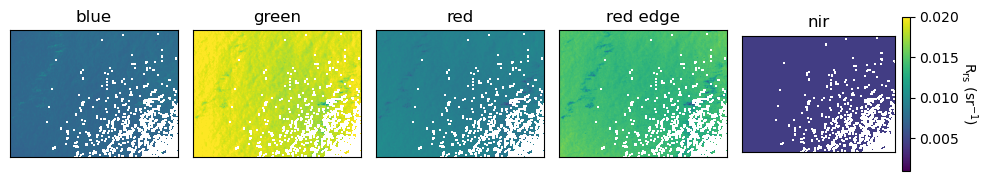

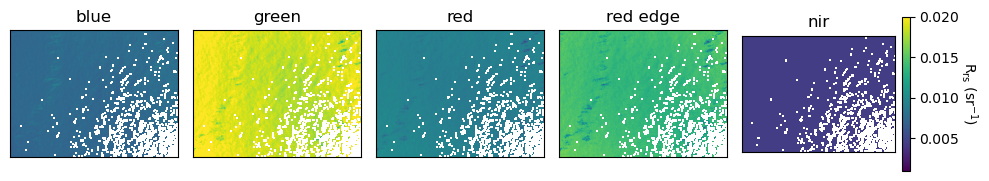

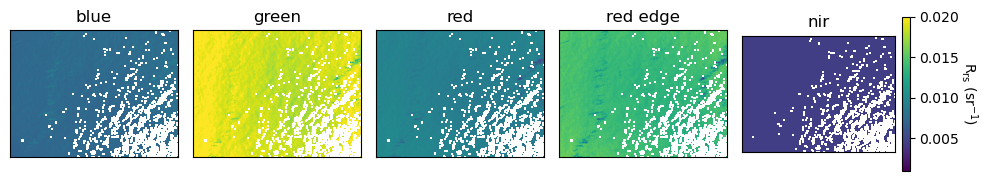

In [11]:
masked_rrs_imgs_hedley, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.masked_rrs_dir, start=0, count=5)
print(img_metadata.index)

for j in range(len(masked_rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

Let's plot the masked Rrs spectra of the first 25 images:

In [ ]:
masked_rrs_imgs_hedley, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.masked_rrs_dir, count=25)

fig, ax = plt.subplots(1,1, figsize=(6,3))

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)), marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$R_{rs}\ (sr^{-1}$)') 
plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

plt.legend(frameon=False)

Let's compare this Rrs spectra to Rrs spectra retrived by a satellite at the same location and time. Below is a plot of Rrs from the Ocean Land Color Imager (OLCI) on board the European satellite, Sentinel-3A. OLCI collects in a few more bands which is why there are more points on the plot. However, the shape looks similar to the MicaSense retrieved Rrs. The troughs at 475 nm and 668 nm is associated with chlorophyll absorption and the peak at 717 nm is likely due to phytoplankton particle scattering. 

<img src="figs/OLCI_Rrs_Lake_Erie.png" width=560 height=500/>

Let's plot the Lt, Lw, Ed spectra as well. First, we need to retrieve all the data.

In [ ]:
lt_imgs, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.lt_dir, count=25)
lw_imgs, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.lw_dir, count=25)
dls_ed = pd.read_csv(project_path+'/dls_ed.csv')
rrs_imgs_hedley, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.rrs_dir, count=25)
masked_rrs_imgs_hedley, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = settings.masked_rrs_dir, count=25)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,5))

axs = axs.ravel()

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

#lt
for i in range(len(lt_imgs)):
    axs[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
axs[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')
axs[0].legend(frameon=False)

#dls ed
ed = pd.read_csv(project_path+'/dls_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    axs[1].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
axs[1].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Mean')

#rrs_imgs_hedley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_hedley)))

for i in range(len(rrs_imgs_hedley)):
    axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('$R_{rs}\ (sr^{-1}$)') 
axs[2].plot(wv, np.nanmean(rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')


#rrs_imgs_hedley_masked
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[3].set_xlabel('Wavelength (nm)')
    axs[3].set_ylabel('$R_{rs}\ (sr^{-1}$)')   
axs[3].plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Mean')

fig.tight_layout() 

The `process_raw_to_rrs()` function also saves images processed to total radiance (Lt) as stacked red-green-blue (RGB) .jpg's in a folder called 'lt_thumbnails'. This is an easy way to quickly view the images to see what the water surface looked like. Let's open a few to take a look:

In [ ]:
def capture_path_to_int(path : str) -> int:
    return int(os.path.basename(path).split('_')[-1].split('.')[0])

lt_thumbnails = sorted(glob.glob(project_path + '/lt_thumbnails/*.jpg'), key = capture_path_to_int)[10:]

fig, axs = plt.subplots(2,3, figsize=(6,4), sharex=True, sharey=True, layout='tight')
axs = axs.ravel()

for i in range(6):
    image = mpimg.imread(lt_thumbnails[i])
    axs[i].imshow(image)
    axs[i].set_title(os.path.basename(lt_thumbnails[i]))

plt.show()

## 4. Convert to point samples

You might be interested in averaging values for every image, to work with point samples. This code calculates the median Rrs across bands and saves them to a Pandas dataframe with the dirname, lat, and lon.

In [ ]:

# Ensure we have an ndarray (helper may return a list)
if not isinstance(masked_rrs_imgs_hedley, np.ndarray):
    masked_rrs_imgs_hedley = np.stack(masked_rrs_imgs_hedley)

# Compute per-image median for first 5 bands (shape -> (n_images, 5))
# We take median across spatial dims (H, W)
medians = np.nanmedian(masked_rrs_imgs_hedley[:, :5, :, :], axis=(2, 3))

# Build dataframe safely and assign median band values
df = img_metadata[['dirname', 'Latitude', 'Longitude']].copy()
df[['rrs_blue', 'rrs_green', 'rrs_red', 'rrs_rededge', 'rrs_nir']] = medians

# Show result
df.head()


Easy to save as a .csv:

In [ ]:
df.to_csv(project_path + '/median_rrs.csv')

## 5. Apply bio-optical algorithms

We can also apply bio-optical algorithms to derive chlorophyll a and total suspended matter (TSM) concentrations. Please see the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html) for more information on each algorithm. Here, we are applying the blended NASA chlorophyll a algorithm (Hu et al., 2019). 

In [12]:
chl_hu_ocx_imgs = dronewq.chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])
print(chl_hu_ocx_imgs.shape)

(5, 928, 1227)


Let's take a quick look at a histogram of all chl values:

11.170641


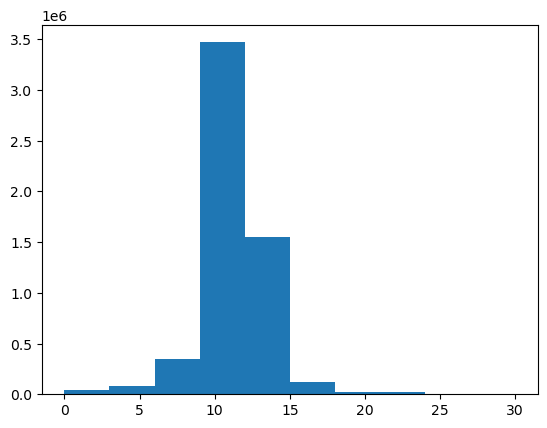

In [13]:
plt.hist(chl_hu_ocx_imgs.ravel(), range=(0, 30))
print(np.nanmedian(chl_hu_ocx_imgs))

The median value looks to be around 11 mg $m^{-3}$, which is reasonable for Lake Erie. 

Now, we can save new .tifs processed with this algorithm. 

In [15]:
dronewq.save_wq_imgs(wq_alg ='chl_hu_ocx') 

/home/bob/.conda/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/bob/.conda/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/bob/.conda/envs/dronewq/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/bob/.conda/envs/dro

Let's visualize a few chl a images.

Index(['capture_1.tif', 'capture_2.tif', 'capture_3.tif', 'capture_4.tif',
       'capture_5.tif', 'capture_6.tif'],
      dtype='object', name='filename')


/home/bob/.conda/envs/dronewq/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


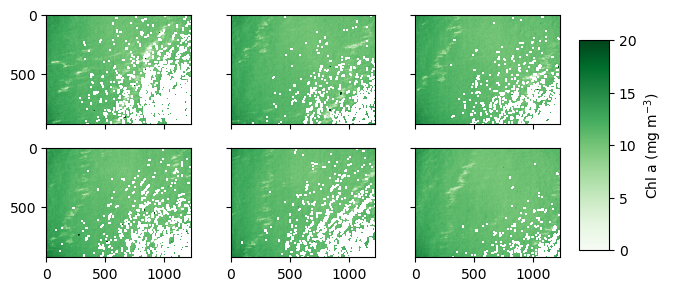

In [16]:
chl_imgs, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = dronewq.settings.wq_dir, start=0, count=6)
print(img_metadata.index)

fig, axs = plt.subplots(2,3, figsize=(6,3), sharex=True, sharey=True, layout='tight')

axs = axs.ravel()

for i in range(6):
    im = axs[i].imshow(chl_imgs[i,0,:,:], cmap='Greens', vmin=0, vmax=20)

cbar_ax = fig.add_axes([0.99, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Chl a (mg $m^{-3}$)')  

plt.show()

We can also save average chl-a/TSM concentrations for each image in dataframe to use as point data:

In [ ]:
project_path=settings.main_dir

In [ ]:
masked_rrs_imgs_hedley, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_imgs')

chl_hu_ocx_imgs = dronewq.chl_hu_ocx(Rrsblue=masked_rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=masked_rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

tsm_nechad_imgs = dronewq.tsm_nechad(Rrsred=masked_rrs_imgs_hedley[:,2,:,:])

# Compute median across spatial dimensions (height, width) for all images at once
chl_hu_ocx_values = np.nanmedian(chl_hu_ocx_imgs, axis=(1, 2))
tsm_nechad_values = np.nanmedian(tsm_nechad_imgs, axis=(1, 2))

df['chl_hu_ocx'] = chl_hu_ocx_values
df['tsm_nechad'] = tsm_nechad_values

df.head()


Easy to save as .csv:

In [ ]:
#save as csv
df.to_csv(project_path + '/median_rrs_and_wq.csv')

We can use this dataframe to map point samples of mean chl-a and TSM concentrations:

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,3), layout='tight')
for i in range(len(df)):  
    g1 = ax[0].scatter(df['Latitude'], df['Longitude'], c=df['chl_hu_ocx'], cmap='Greens', vmin=10, vmax=12)
    g2 = ax[1].scatter(df['Latitude'], df['Longitude'], c=df['tsm_nechad'], cmap='YlOrRd', vmin=5, vmax=6)

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (mg $m^{-3}$)', rotation=270, labelpad=12)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('TSM (mg/L)', rotation=270, labelpad=12)

plt.show()

## 6. Georeference and mosaic chlorophyll a images

We can georeference the images based on the sensor yaw, pitch, roll, lat, lon, and altitude. Note that georeferencing can be inaccurate if the yaw, pitch, and roll information is imprecise. Let's look at the options in the `georeference()` function.

In [ ]:
?georeference

We have two options here. We can set fixed georeferencing parameters, or allow the function to use parameters saved in the metadata.

In this example, the image metadata lists the altitude around 260-265 m; however, the altitude was set at 87 m in the flight planning software. Therefore, we will set the altitude to a fixed altitude of 87 m. 

If you can maintain a consistent sensor yaw angle throughout the whole flight, you should use a single fixed angle. If your sensor changes yaw angle during every transect (such as in this example), a different yaw angle should be provided in the function for each transect. The `georeference()` function can read in a `lines` parameter that can be created either manually or you can use the function `compute_flight_lines()` to automatically produce a list of capture indices per transect with the median yaw angle, ignoring capturing collected during turns. More information can be found in the Processing and theory section in the [DroneWQ readthedocs](https://dronewq.readthedocs.io/en/latest/index.html).

It is recommended to run the `georeference()` function on a few captures that contain a shoreline or land if possible and plot them with a satellite basemap or pull them into a GIS software to assess the georeferencing. We have provided examples here by manually creating a new folder of rrs_hedley_subset and lt_thumbnails_subset with captures 443 to 450 containing the shoreline.

1. Running `georeference()` with the automatic `compute_flight_lines()` function produces a flight_lines list with yaw angle changing from 207 to 25 degrees:

In [ ]:
rrs_hedley_subset, img_metadata = dronewq.retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley_subset', start=432, count=18)
img_metadata = img_metadata.reset_index()

flight_lines = dronewq.compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)
flight_lines

We can edit the metadata to change file extension from '.tif' to '.jpg' and run `georeference()` on the lt_thumbnails_subset:

In [ ]:
img_metadata['filename'] = img_metadata['filename'].apply(lambda x : x.replace('.tif', '.jpg')) 

input_dir = os.path.join(project_path, 'lt_thumbnails_subset') 
output_dir = os.path.join(project_path, 'automatic_georeferenced_lt_thumbnails_subset')
lines = flight_lines

dronewq.georeference(img_metadata, input_dir, output_dir, lines) 

When we plot these images in QGIS, it looks like: <br>
<img src="figs/automatic_flightlines_QGIS.png" width=400 height=200/>

You can see that using the metadata yaw angle in georeferencing doesn't always lead to accurate georeferencing. 

2. Running `georeference()` using fixed yaw angles of 90 and 270 degrees:

In [ ]:
flight_lines = dronewq.compute_flight_lines(img_metadata.Yaw, 87, 0, 0, threshold=100)

even_yaw = 90
odd_yaw = 270
threshold = np.median(img_metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
    
flight_lines

In [ ]:
input_dir = os.path.join(project_path, 'lt_thumbnails_subset') 
output_dir = os.path.join(project_path, 'manual_georeferenced_lt_thumbnails_subset')
lines = flight_lines

dronewq.georeference(img_metadata, input_dir, output_dir, lines) 

When we plot these images in QGIS: <br>
<img src="figs/manual_flightlines_QGIS.png" width=400 height=200/>

You can see that using these fixed yaw angles leads to better georeferencing where the shoreline better matches to the satellite basemap.

Therefore, we will use fixed yaw angles of 90 and 270 degrees to georeference the masked_chl_hu_ocx_imgs:

In [ ]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))

flight_lines = dronewq.compute_flight_lines(metadata.Yaw, 87, 0, 0)   
even_yaw = 90
odd_yaw = 270
threshold = np.median(metadata.Yaw)
for line in flight_lines:
    line.update(yaw = even_yaw if line['yaw'] < threshold else odd_yaw)
flight_lines[0:5]

In [ ]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
input_dir = os.path.join(project_path, 'masked_chl_hu_ocx_imgs') 
output_dir = os.path.join(project_path, 'georeferenced_masked_chl_hu_ocx')
lines = flight_lines

dronewq.georeference(metadata, input_dir, output_dir, lines) 

Let's plot a few of these georeferenced images by the shoreline:

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_444.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/georeferenced_masked_chl_hu_ocx/capture_445.tif", 
                                           vmin=5, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0.set_title('Hu OCX Chl Alg')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

We can mosaic all of the individual georeferenced images. Let's look at the options.

In [ ]:
?mosaic

We will make a mosaic from all the georeferenced chl images, calculating the mean of overlapping pixels. 

In [ ]:
input_dir = os.path.join(project_path, 'georeferenced_masked_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

dronewq.mosaic(input_dir, output_dir, output_name = 'mean_mosaic_chl_hu_ocx',
           method='mean', band_names = None) 

Now let's plot the mosaicked image.

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = dronewq.plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.Esri.WorldImagery)
ax_0.set_title('Hu OCX Chl')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

We can also downsample or reduce the spatial resolution of the mosaic. This is helpful to reduce the file size of a large mosaic. 

In [ ]:
?downsample

We will downsample the width and height of the mosaic by 15%, using a nearest neighbor resampling algorithm. 

In [ ]:
input_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

downsample(input_dir, output_dir, scale_x = 15, scale_y = 15, method = Resampling.nearest)

And we can plot it

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename="Lake_Erie/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx_x_15_y_15_method_nearest.tif", 
                                           vmin=5, vmax=15, cmap='Greens', norm=None, basemap = cx.providers.Esri.WorldImagery)
ax_0.set_title('Hu OCX Chl Downsampled')
plt.colorbar(mappable_0, label='Chlorophyll a (mg $m^{-3}$)')

Some striping in the mosaic is visible due to the drone/sensor changing yaw angles every transect. Processing and mosaicking a larger dataset has the potential to reveal water quality patterns or algal blooms. 